In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
ls

gdrive/  sample_data/


In [3]:
cd gdrive/My Drive/Graduation-Project-Sentiment-Stock-price/analysis

/content/gdrive/My Drive/Graduation-Project-Sentiment-Stock-price/analysis


In [4]:
ls

 data/                     final_edition.ipynb   News.ipynb     test.ipynb
'final_edition(2).ipynb'   LSTM.ipynb            Prices.ipynb


In [5]:
import re
import sys
import os
import os.path
import random
from time import time
from datetime import datetime

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-bright')

import plotly
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.tools as tls
plotly.offline.init_notebook_mode(connected=True)

from wordcloud import WordCloud

import nltk
nltk.download('popular')
from nltk.corpus import words,stopwords
from nltk.tokenize import sent_tokenize,word_tokenize,WordPunctTokenizer 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score,accuracy_score,confusion_matrix,classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import QuantileTransformer,MinMaxScaler,StandardScaler,scale

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical

# from scipy.interpolate import spline

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

Using TensorFlow backend.


# I. Market Data EDA & Preprocessing

In [6]:
df_market = pd.read_csv('data/GOOG_price_4y.csv')
df_market.head()

,date,close,volume,open,high,low
0,16:00,25.74,"213,573",26.29,26.44,25.72
1,2019/08/27,25.74,215200.0000,26.15,26.44,25.72
2,2019/08/26,26.09,187412.0000,26.38,26.63,25.96
3,2019/08/23,26.05,202607.0000,26.91,26.99,25.94
4,2019/08/22,27.01,273461.0000,26.75,27.31,26.75


In [7]:
df_market.shape

(1008, 6)

In [8]:
df_market.date = pd.to_datetime(df_market['date'])
df_market.date.dtype

dtype('<M8[ns]')

In [9]:
df_market.describe()

,close,open,high,low
count,1008.000000,1008.000000,1008.000000,1008.000000
mean,30.618522,30.636984,31.013913,30.232632
std,4.254088,4.264803,4.290325,4.217482
min,20.220000,20.370000,20.920000,20.160000
25%,27.527500,27.515000,27.900000,27.165000
50%,30.025000,30.000000,30.350000,29.600000
75%,33.150000,33.155000,33.500000,32.750000
max,41.840000,41.990000,42.719900,41.470000


In [0]:
df_market['move_class'] = 0
df_market['close_move'] = 0
for index in range(0,df_market.shape[0]-1):
    ct = float(df_market.loc[index,['close']])
    ct_1 = float(df_market.loc[index + 1,['close']])
    df_market.loc[index + 1,['close_move']] = ct_1 - ct
    if ct < ct_1:
        df_market.loc[index + 1,['move_class']] = 1
    elif ct > ct_1:
        df_market.loc[index + 1,['move_class']] = -1
    else:
        df_market.loc[index + 1,['move_class']] = 0

In [0]:
def del_extrem(array):
  '''Filter extrem values'''
  sigma = array.std()
  mu = array.mean()
  array[array > mu + 3*sigma] = mu + 3*sigma
  array[array < mu - 3*sigma] = mu - 3*sigma
  
  return array

In [0]:
df_market['close_move'] = del_extrem(df_market['close_move'].values)

In [13]:
start_date = datetime.strptime('2016-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2018-12-31', '%Y-%m-%d')
mask = (df_market['date'] >= start_date) & (df_market['date'] <= end_date)
df_market = df_market.loc[mask]
df_market.tail()

,date,close,volume,open,high,low,move_class,close_move
915,2016-01-08,31.76,461498.0000,32.62,32.72,31.67,1,0.240000
916,2016-01-07,32.32,402039.0000,33.85,33.96,32.16,1,0.560000
917,2016-01-06,34.59,571906.0000,34.74,35.29,34.51,1,1.690775
918,2016-01-05,35.25,211639.0000,35.23,35.46,35.05,1,0.660000
919,2016-01-04,35.23,494085.0000,35.47,35.54,34.61,-1,-0.020000


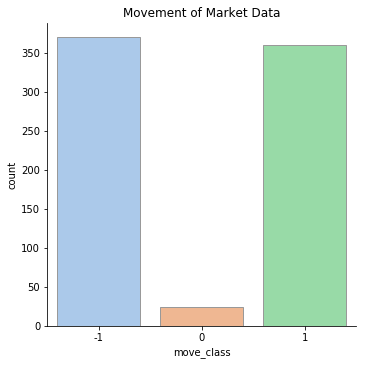

In [14]:
sns.catplot(x='move_class', kind='count', palette='pastel', edgecolor='.6', data=df_market)
plt.title('Movement of Market Data')
plt.show()

In [15]:
enable_plotly_in_cell()

market_data = []
market_data.append(go.Scatter(
        x = df_market['date'].dt.strftime(date_format='%Y-%m-%d').values,
        y = df_market['close'].values,
        name = 'GOOG'
    ))
layout = go.Layout(dict(title = "Closing prices of GOOG (2016-01-01 to 2018-12-31)",
                  xaxis = dict(title = 'Date'),
                  yaxis = dict(title = 'Close Price (USD)'),
                  ),legend=dict(orientation="h"))
py.iplot(dict(data=market_data, layout=layout), filename='market_data_line')

Output hidden; open in https://colab.research.google.com to view.

In [16]:
enable_plotly_in_cell()

close_move = []
close_move.append(go.Scatter(
        x = df_market['date'].dt.strftime(date_format='%Y-%m-%d').values,
        y = df_market['close_move'].values,
        name = 'GOOG close_delta'
    ))
layout = go.Layout(dict(title = "close_delta of GOOG (2016-01-01 to 2018-12-31)",
                  xaxis = dict(title = 'Date'),
                  yaxis = dict(title = 'Close delta'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=close_move, layout=layout), filename='close_delta_line')

Output hidden; open in https://colab.research.google.com to view.

# II. News Data EDA

## 1.Load data

In [17]:
df_news = pd.read_csv('../analysis/data/GOOGnews.csv', sep='\t')
df_news.head()

,date,title,url,description,text
0,01-12-2016,UPDATE 1-Google will add more partners for sel...,https://www.reuters.com/article/autoshow-detro...,"DETROIT, Jan 12 Alphabet Inc's Google wants t...",(Adds background on Google’s and automakers’ s...
1,01-12-2016,Ford Chairman: 'We are in an experimental stage',https://www.reuters.com/article/us-autoshow-de...,DETROIT Ford Motor Co Chairman Bill Ford said...,DETROIT (Reuters) - Ford Motor Co (F.N) Chairm...
2,01-20-2016,UPDATE 2-News Corp denies rumors of Twitter bid,https://www.reuters.com/article/twitter-ma-new...,Jan 20 Rupert Murdoch's News Corp said rumors ...,(Reuters) - Rupert Murdoch’s News Corp said ru...
3,01-22-2016,Google to pay 130 mln pounds in back taxes in ...,https://www.reuters.com/article/uk-alphabet-ta...,"Jan 22 Google, now part of Alphabet Inc , agre...","Jan 22 (Reuters) - Google, now part of Alphabe..."
4,01-23-2016,"Google to pay $185 million UK back taxes, crit...",https://www.reuters.com/article/us-alphabet-ta...,LONDON Google said on Friday it agreed to pay ...,LONDON (Reuters) - Google has agreed to pay 13...


In [18]:
df_news.shape

(781, 5)

In [19]:
# cols_name = ['ticker','company','date','title','content','type']
# df_news.columns = cols_name
print(df_news.date.dtype)

object


In [0]:
# sns.catplot(x='type', kind='count', palette='pastel', edgecolor='.6', data=df_news)

In [0]:
def num_to_date(num):
    text = str(num)
    date = datetime.strptime(text, '%m-%d-%Y')
    return date

# text = '01-12-2016'
# print(num_to_date(text))
df_news['date'] = df_news['date'].apply(lambda row: num_to_date(row))

In [22]:
news_mask = (df_news['date'] >= start_date) & (df_news['date'] <= end_date)
df_news = df_news.loc[news_mask]
df_news.tail()

,date,title,url,description,text
776,2018-12-10,GRAPHIC-Deep losses leave Big Tech with small ...,https://www.reuters.com/article/usa-stocks-ear...,"SAN FRANCISCO, Dec 10 Deep losses in Amazon In...",SAN FRANCISCO (Reuters) - Deep losses in Amazo...
777,2018-12-10,Australian watchdog wants a regulator for domi...,https://www.reuters.com/article/us-australia-s...,SYDNEY Australia's competition watchdog on Mon...,SYDNEY (Reuters) - Australia’s competition wat...
778,2018-12-10,UPDATE 3-Australian watchdog wants a regulator...,https://www.reuters.com/article/australia-secu...,"* ACCC says Facebook, Google dominate online a...",SYDNEY (Reuters) - Australia’s competition wat...
779,2018-12-20,UPDATE 2-PE giant KKR cuts buyout price for Au...,https://www.reuters.com/article/myob-ma-kkr/up...,* MYOB shares down 11 pct (Recasts on technolo...,SYDNEY (Reuters) - U.S. private equity giant K...
780,2018-12-21,Apple changes how it reports U.S. national sec...,https://www.reuters.com/article/us-apple-secur...,Apple Inc on Thursday changed how it reports ...,FILE PHOTO: The various colors of newly releas...


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



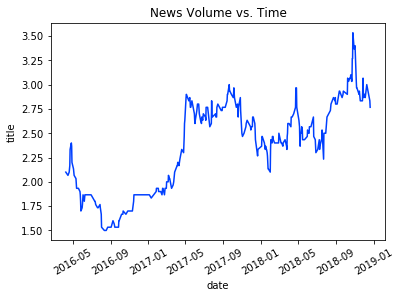

In [23]:
news_volume = df_news.groupby('date')['title'].count().reset_index()
news_volume = news_volume.set_index('date').rolling(30).mean()
sns.lineplot(x=news_volume.index, y=news_volume['title'])
plt.title('News Volume vs. Time')
plt.xticks(rotation=30)
plt.show()

## 2. Data preprocessing and Visualisation

### 2.1 Build a new stopwords list

In [0]:
auditor_sw = []
with open('data/wordlist/StopWords_Auditor.txt','r') as fa:
    lines = fa.readlines()
    for line in lines:
        auditor_sw.append(line.strip())

In [0]:
datesAndNum_sw = []
with open('data/wordlist/StopWords_DatesandNumbers.txt','r') as fdn:
    lines = fdn.readlines()
    for line in lines:
        datesAndNum_sw.append(line.strip())

In [0]:
generic_sw = []
with open('data/wordlist/StopWords_Generic.txt','r') as fg:
    lines = fg.readlines()
    for line in lines:
        generic_sw.append(line.strip())

In [0]:
glong_sw = []
with open('data/wordlist/StopWords_GenericLong.txt','r') as fgl:
    lines = fgl.readlines()
    for line in lines:
        glong_sw.append(line.strip())

In [0]:
geographic_sw = []
with open('data/wordlist/StopWords_Geographic.txt','r') as fgeo:
    lines = fgeo.readlines()
    for line in lines:
        geographic_sw.append(line.strip())

In [0]:
new_stopwords = auditor_sw + datesAndNum_sw + generic_sw + glong_sw + geographic_sw

### 2.2 Clean the news data

In [0]:
def datacleaner(text):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    wps = WordPunctTokenizer().tokenize(text)
    wps = [w for w in wps if w not in stopwords.words('english')] # remove buit-in stopwords
    wps = [w for w in wps if w not in new_stopwords] # remove 
    words = [w.lower() for w in wps if w.isalpha()] # lower case and remove punctuation
    words = [lemmatizer.lemmatize(w) for w in words] # Lemmatisation
#     words = [stemmer.stem(w) for w in words] # Normalisation,Stemming
    
    return words

In [0]:
df_news2 = df_news.copy()
df_news2['title'] = df_news2['title'].apply(lambda row: datacleaner(row))
df_news2['description'] = df_news2['description'].apply(lambda row: datacleaner(row))
df_news2['text'] = df_news2['text'].apply(lambda row: datacleaner(row))

In [32]:
df_news2['title'].head()

0    [update, google, add, partner, driving, car, e...
1            [ford, chairman, we, experimental, stage]
2    [update, news, corp, denies, rumor, twitter, bid]
3         [google, pay, mln, pound, back, tax, uk, ft]
4        [google, pay, million, uk, back, tax, critic]
Name: title, dtype: object

In [33]:
df_news2['description'].head()

0    [jan, alphabet, inc, google, form, partnership...
1    [ford, motor, co, chairman, bill, ford, monday...
2    [jan, rupert, murdoch, news, corp, rumor, comp...
3    [jan, google, part, alphabet, inc, agreed, pay...
4    [google, friday, agreed, pay, uk, tax, authori...
Name: description, dtype: object

In [34]:
df_news2['text'].head()

0    [add, background, google, automaker, driving, ...
1    [reuters, ford, motor, co, f, n, chairman, bil...
2    [reuters, rupert, murdoch, news, corp, rumor, ...
3    [jan, reuters, google, part, alphabet, inc, ag...
4    [reuters, google, agreed, pay, million, pound,...
Name: text, dtype: object

### 2.3 Concatenate the title and content into one document

In [35]:
# 合并title and content
df_news2['full_text'] = df_news2['title'] + df_news2['description'] + df_news2['text']
df_news2['full_text'].head()

0    [update, google, add, partner, driving, car, e...
1    [ford, chairman, we, experimental, stage, ford...
2    [update, news, corp, denies, rumor, twitter, b...
3    [google, pay, mln, pound, back, tax, uk, ft, j...
4    [google, pay, million, uk, back, tax, critic, ...
Name: full_text, dtype: object

### 2.4 Visualize the frequency of the words

In [0]:
text_wl = []
for index,row in df_news2.iterrows():
    for word in row['full_text']:
        text_wl.append(word)

text_wl = list(set(text_wl))
whole_text = ' '.join(text_wl)

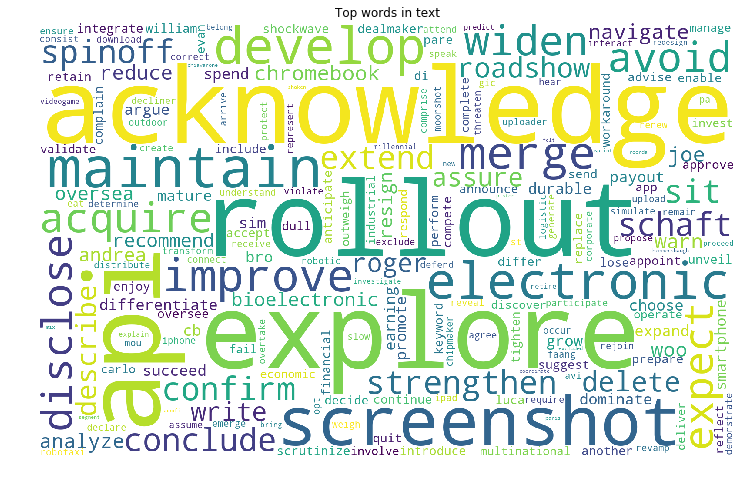

In [37]:
wc = WordCloud(background_color='white',
              max_font_size=None,
              width=1600,
              height=1000)
wc.generate(whole_text)
plt.figure(figsize=(16,8))
plt.imshow(wc)
plt.title('Top words in text')
plt.axis('off')
plt.show()

## 3. Build the polarity dictionary

### 3.1 Financial sentiment word list

In [38]:
financial_sheets = pd.read_excel('data/wordlist/LoughranMcDonald_SentimentWordLists_2018.xlsx', 
                                 sheet_name=['Negative','Positive'])
financial_sheets['Negative'].head()

,ABANDON
0,ABANDONED
1,ABANDONING
2,ABANDONMENT
3,ABANDONMENTS
4,ABANDONS


In [0]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

### 3.2 General sentiment word

In [40]:
# 读取general negative文件
path = 'data/wordlist/negative-words.txt'
general_neg = []
with open(path, 'r', encoding='ISO-8859-1') as f:
    ls = f.readlines()
    for word in ls:
        general_neg.append(word.strip())

# 创建negative_words字典
neg_dict = financial_sheets['Negative'].values
neg_dict = neg_dict.reshape(1, len(neg_dict)).tolist()[0]
neg_dict = neg_dict + general_neg
neg_dict = list(map(lambda x:x.lower(),neg_dict))
# neg_dict = list(set([stemmer.stem(w) for w in neg_dict]))
neg_dict = list(set(lemmatizer.lemmatize(w) for w in neg_dict))
print(neg_dict[:20])

['antipathy', 'uglier', 'gimmicking', 'over-priced', 'hatefully', 'pollute', 'besmirch', 'rejection', 'absurdness', 'kook', 'flee', 'uncertain', 'discourteous', 'convicted', 'seizing', 'pique', 'unprofitable', 'incoherently', 'rhetoric', 'rough']


In [41]:
# 读取general positive文件
path = 'data/wordlist/positive-words.txt'
general_pos = []
with open(path, 'r', encoding='ISO-8859-1') as f:
    ls = f.readlines()
    for word in ls:
        general_pos.append(word.strip())
        
# 创建positive_words字典
pos_dict = financial_sheets['Positive'].values
pos_dict = pos_dict.reshape(1, len(pos_dict)).tolist()[0]
pos_dict = pos_dict + general_pos
pos_dict = list(map(lambda x:x.lower(),pos_dict))
# pos_dict = list(set([stemmer.stem(w) for w in pos_dict]))
pos_dict = list(set(lemmatizer.lemmatize(w) for w in pos_dict))
print(pos_dict[:20])

['interest', 'thoughtfully', 'healthful', 'bargain', 'trumpet', 'amity', 'brainiest', 'cozy', 'greatness', 'enthusiasm', 'desiring', 'rejoicing', 'unbound', 'unreal', 'embolden', 'prestigious', 'excelent', 'charm', 'feature-rich', 'pride']


## 4. Calculate daily sentiment score

In [0]:
def daily_sentiment_score(word_list):
    '''统计pos/neg单词个数并计算daily_sent_score'''
    poscount = 0
    negcount = 0
    score = 0
    for word in word_list:
        if word in pos_dict:
            poscount += 1
        elif word in neg_dict:
            negcount += 1
    if poscount > negcount:
        score = 2 * poscount / (poscount + negcount) - 1
    elif poscount == negcount:
        score = 0
    else:
        score = 1 - 2 * negcount / (poscount + negcount)
    return score

In [0]:
def group_news_bydate(df):
    daily_news_text = []
    for index, row in df.iterrows(): 
        daily_news_text += row['full_text']
    daily_sent_score = daily_sentiment_score(daily_news_text)
    return daily_sent_score

In [0]:
df_daily = df_news2.groupby(['date']).apply(group_news_bydate)

In [0]:
def group_news_bydate2(df):
    group_text = ''
    for index, row in df.iterrows():
        this_text = row['title'] + row['description'] + row['text']
        group_text += this_text
    return group_text

In [46]:
daily_text = df_news.groupby(['date']).apply(group_news_bydate2)
daily_text.head()

date
2016-01-12    UPDATE 1-Google will add more partners for sel...
2016-01-20    UPDATE 2-News Corp denies rumors of Twitter bi...
2016-01-22    Google to pay 130 mln pounds in back taxes in ...
2016-01-23    Google to pay $185 million UK back taxes, crit...
2016-01-25    Google to face grilling by UK lawmakers over t...
dtype: object

In [47]:
index = df_daily.index
documents = daily_text.values
scores = df_daily.values

d = {'text':documents, 'sent_score':scores}
df_textsent = pd.DataFrame(data=d, index=index)
df_textsent.head()

,text,sent_score
date,,
2016-01-12,UPDATE 1-Google will add more partners for sel...,0.400000
2016-01-20,UPDATE 2-News Corp denies rumors of Twitter bi...,-0.454545
2016-01-22,Google to pay 130 mln pounds in back taxes in ...,0.111111
2016-01-23,"Google to pay $185 million UK back taxes, crit...",-0.304348
2016-01-25,Google to face grilling by UK lawmakers over t...,-0.538462


In [48]:
df_textsent['sent_score'].describe()

count    322.000000
mean      -0.000163
std        0.448635
min       -0.846154
25%       -0.333333
50%       -0.043798
75%        0.294118
max        1.000000
Name: sent_score, dtype: float64

In [0]:
df_textsent['sent_score'] = del_extrem(df_textsent['sent_score'].values)

In [50]:
df_textsent['sent_score'].describe()

count    322.000000
mean      -0.000163
std        0.448635
min       -0.846154
25%       -0.333333
50%       -0.043798
75%        0.294118
max        1.000000
Name: sent_score, dtype: float64

In [51]:
enable_plotly_in_cell()

sent_score = []
sent_score.append(go.Scatter(
        x = df_textsent.index.strftime(date_format='%Y-%m-%d').values,
        y = df_textsent.sent_score,
        name = 'GOOG'
    ))
layout = go.Layout(dict(title = "Sentiment Score of GOOG (2016-01-01 to 2018-12-31)",
                  xaxis = dict(title = 'Date'),
                  yaxis = dict(title = 'Sentiment Score'),
                  ),legend=dict(
                orientation="h"))
py.iplot(dict(data=sent_score, layout=layout), filename='sent_score_line')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Add class label
def add_label(s):
    if s < 0:
        return -1
    elif s > 0:
        return 1
    else:
        return 0

In [53]:
df_textsent['label'] = df_textsent['sent_score'].apply(lambda row: add_label(row))
df_textsent.head()

,text,sent_score,label
date,,,
2016-01-12,UPDATE 1-Google will add more partners for sel...,0.400000,1
2016-01-20,UPDATE 2-News Corp denies rumors of Twitter bi...,-0.454545,-1
2016-01-22,Google to pay 130 mln pounds in back taxes in ...,0.111111,1
2016-01-23,"Google to pay $185 million UK back taxes, crit...",-0.304348,-1
2016-01-25,Google to face grilling by UK lawmakers over t...,-0.538462,-1


In [54]:
df_textsent.shape

(322, 3)

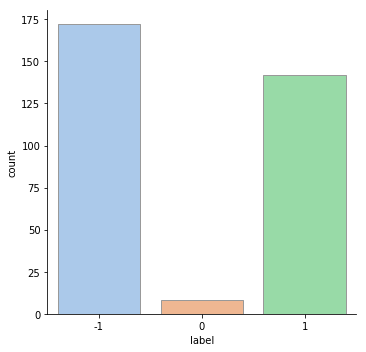

In [55]:
sns.catplot(x='label', kind='count', palette='pastel', edgecolor='.6', data=df_textsent)

## 5. Check the Accuracy of Detection Result

In [56]:
new_df_market = df_market.set_index('date')
new_df_market.head()

,close,volume,open,high,low,move_class,close_move
date,,,,,,,
2018-12-31,22.11,477939.0000,21.88,22.2000,21.5800,-1,-0.08
2018-12-28,21.76,699178.0000,22.06,22.2261,21.4941,-1,-0.35
2018-12-27,21.96,854607.0000,21.28,21.9700,21.0200,1,0.20
2018-12-26,21.68,610109.0000,20.37,21.7000,20.1600,-1,-0.28
2018-12-24,20.22,461647.0000,20.80,20.9200,20.2100,-1,-1.46


In [57]:
df_merge = pd.merge(df_textsent[['sent_score','label']], new_df_market[['close_move','move_class']], how='inner',
                    left_index=True,right_index=True)
df_merge.head()

,sent_score,label,close_move,move_class
date,,,,
2016-01-12,0.400000,1,1.26,1
2016-01-20,-0.454545,-1,-0.90,-1
2016-01-22,0.111111,1,1.08,1
2016-01-25,-0.538462,-1,-1.07,-1
2016-01-26,0.157895,1,0.56,1


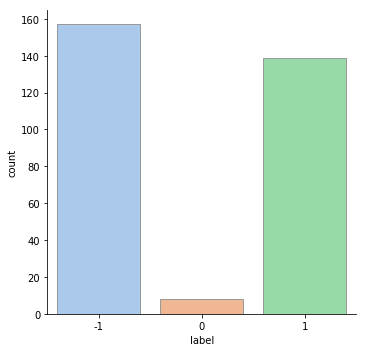

In [58]:
sns.catplot(x='label', kind='count', palette='pastel', edgecolor='.6', data=df_merge)

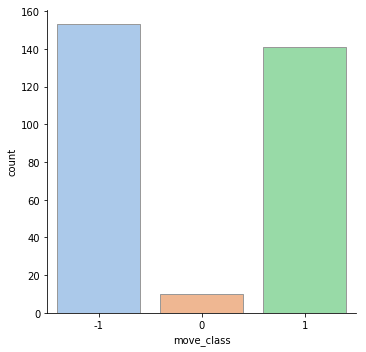

In [59]:
sns.catplot(x='move_class', kind='count', palette='pastel', edgecolor='.6', data=df_merge)

In [60]:
df_merge.shape

(304, 4)

### 5.1 General Checking

In [61]:
correct = 0
mistake = 0
acc = 0

# new_df_market.index
# new_dataset.index
for index, row in df_merge.iterrows():
    if row['label'] == row['move_class']:
        correct += 1
    else:
        mistake += 1
acc = correct / (correct + mistake)
print(acc)

0.4967105263157895


### 5.2 Rolling window & Z-Score

In [0]:
def zscore(x,window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddpf=0).shift(1)
    z = (x-m)/s
    return z

In [0]:
N = 30 # window
roll_market = df_merge['close_move']
roll_sent = df_merge['sent_score']
res_market = zscore(roll_market, N)
res_sent = zscore(roll_sent, N)

In [64]:
print(res_market.shape,res_sent.shape)

(304,) (304,)


In [0]:
x1 = res_market.index.strftime(date_format='%Y-%m-%d').values
y1 = res_market.values.reshape(res_market.values.size,1)
x2 = res_sent.index.strftime(date_format='%Y-%m-%d').values
y2 = res_sent.values.reshape(res_sent.values.size,1)

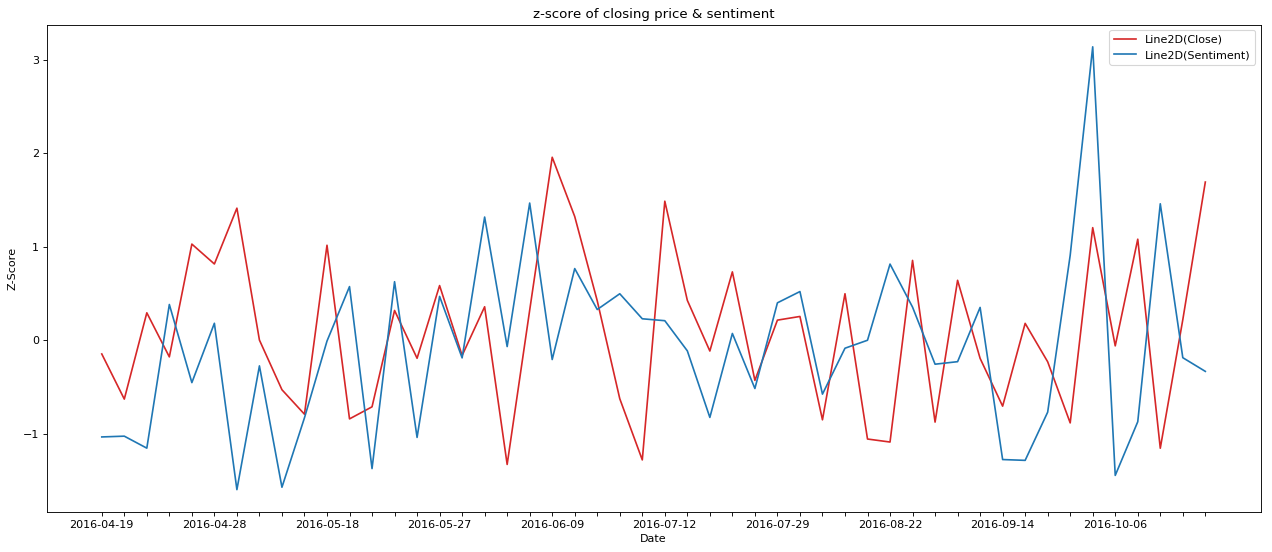

In [66]:
# Draw the line
fig, ax = plt.subplots(1, 1, figsize=(16,7), dpi=80)
line1, = ax.plot(x1[N:N+50], y1[N:N+50], color='tab:red', label='Close')
line2, = ax.plot(x2[N:N+50], y2[N:N+50], color='tab:blue', label='Sentiment')

# Decorations
ax.set_xlabel('Date')
ax.set_ylabel('Z-Score')
ax.set_title('z-score of closing price & sentiment')
ax.legend([line1,line2])
for label in ax.get_xticklabels():
    label.set_visible(False)
for label in ax.get_xticklabels()[::5]:
    label.set_visible(True)
fig.tight_layout()
plt.show()

In [0]:
def minmax(x,window):
  r = x.rolling(window=window)
  x_min = r.min().shift(1)
  x_max = r.max().shift(1)
  z = (x - x_min) / (x_max - x_min)
  return z

In [0]:
N = 30
roll_market2 = df_merge['close_move']
roll_sent2 = df_merge['sent_score']
res_market2 = minmax(roll_market, N)
res_sent2 = minmax(roll_sent, N)

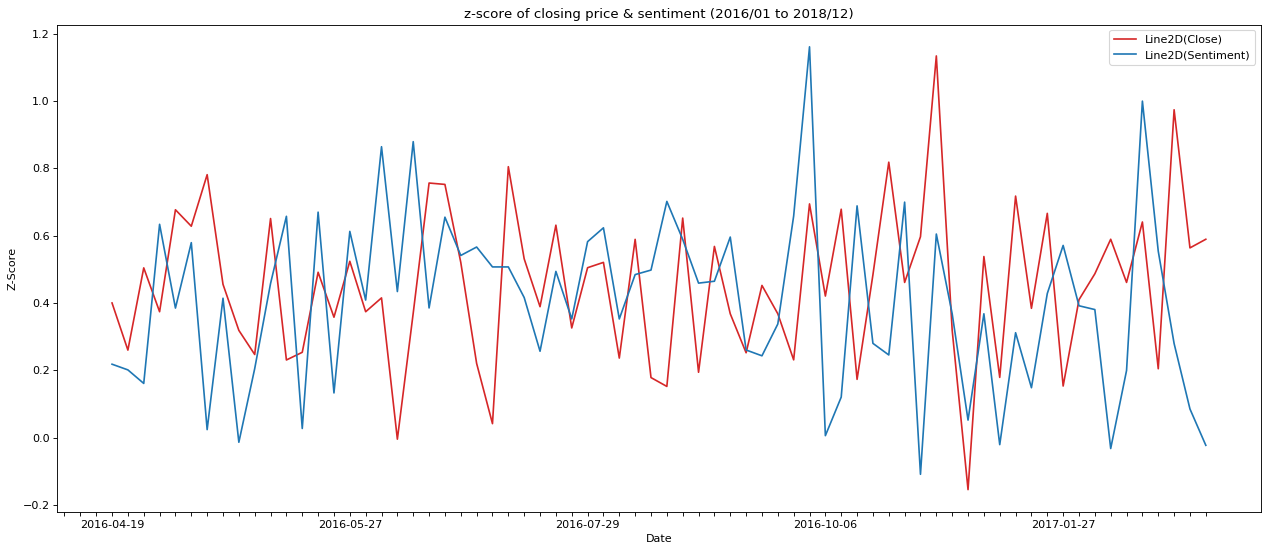

In [69]:
# Draw the line
fig, ax = plt.subplots(1, 1, figsize=(16,7), dpi=80)
line1, = ax.plot(res_market2.index.strftime(date_format='%Y-%m-%d').values[:100],
        res_market2.values.reshape(res_market2.values.size,1)[:100], color='tab:red', label='Close')
line2, = ax.plot(res_sent2.index.strftime(date_format='%Y-%m-%d').values[:100],
        res_sent2.values.reshape(res_sent2.values.size,1)[:100], color='tab:blue', label='Sentiment')

# Decorations
ax.set_xlabel('Date')
ax.set_ylabel('Z-Score')
ax.set_title('z-score of closing price & sentiment (2016/01 to 2018/12)')
ax.legend([line1,line2])
for label in ax.get_xticklabels():
    label.set_visible(False)
for label in ax.get_xticklabels()[::15]:
    label.set_visible(True)
fig.tight_layout()
plt.show()

## 6. Document Representation

In [0]:
text = df_textsent['text']
target = df_textsent['label']
train_set, test_set, train_target, test_target = train_test_split(text, target, random_state=1, test_size=0.3)

In [71]:
print(train_set.shape, train_target.shape)
print(test_set.shape, test_target.shape)

(225,) (225,)
(97,) (97,)


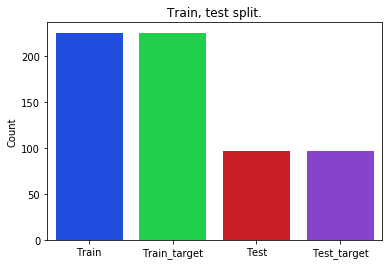

In [72]:
sns.barplot(['Train','Train_target','Test','Test_target'],[train_set.size, train_target.size, test_set.size, 
                                                           test_target.size])
plt.title('Train, test split.')
plt.ylabel('Count')
plt.show()

In [0]:
vectorizer = TfidfVectorizer(max_df=0.9,min_df=0.01,max_features=1000,
                             tokenizer=datacleaner, use_idf=True,ngram_range=(1,1))

In [0]:
train_tfidf_vec = vectorizer.fit_transform(train_set.values)
words = vectorizer.get_feature_names()
test_tfidf_vec = vectorizer.transform(test_set.values)

In [75]:
print(words[:50])

['aapl', 'access', 'account', 'accounting', 'accused', 'acquired', 'acquisition', 'action', 'activity', 'ad', 'add', 'added', 'adding', 'addition', 'additional', 'address', 'adlerour', 'administration', 'advanced', 'advertiser', 'advertising', 'advisor', 'agency', 'ago', 'agreed', 'agreement', 'ahead', 'ai', 'aim', 'aimed', 'algorithm', 'allegation', 'alleged', 'alleging', 'alliance', 'allowing', 'alsup', 'alternative', 'amazon', 'america', 'american', 'amid', 'amount', 'amzn', 'analyst', 'android', 'announced', 'annual', 'answer', 'anthony']


In [76]:
print(np.around(train_tfidf_vec, decimals=3).toarray())
print(train_tfidf_vec.toarray().shape)

[[0.    0.    0.025 ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.497 0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]
(225, 1000)


## 7. Classifier Learning

### 7.1 Naive-Bayes Classifier

In [77]:
clf_NB = MultinomialNB()
clf_NB.fit(train_tfidf_vec, train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [78]:
print('The accuracy score of Naive-Bayes: \n\n\tTrain data set:  %f, \tTest data set:  %f' % \
     (clf_NB.score(train_tfidf_vec.toarray(), train_target), clf_NB.score(test_tfidf_vec.toarray(), test_target)))

The accuracy score of Naive-Bayes: 

	Train data set:  0.893333, 	Test data set:  0.680412


In [79]:
clf_NB2 = GaussianNB()
clf_NB2.fit(train_tfidf_vec.toarray(), train_target)

GaussianNB(priors=None, var_smoothing=1e-09)

In [80]:
print('The accuracy score of Naive-Bayes: \n\n\tTrain data set:  %f, \tTest data set:  %f' % \
     (clf_NB2.score(train_tfidf_vec.toarray(), train_target), clf_NB2.score(test_tfidf_vec.toarray(), test_target)))

The accuracy score of Naive-Bayes: 

	Train data set:  0.968889, 	Test data set:  0.711340


### 7.2 Random Forest Classifier

In [81]:
clf_RF = RandomForestClassifier(n_estimators=100, max_depth = 25, min_samples_leaf= 3, 
                             min_samples_split=3, random_state = 1, n_jobs = -1, verbose = 1)
clf_RF.fit(train_tfidf_vec, train_target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=1,
                       warm_start=False)

In [82]:
print('The accuracy score of Naive-Bayes: \n\n\tTrain data set:  %f, \tTest data set:  %f' % \
     (clf_RF.score(train_tfidf_vec, train_target), clf_RF.score(test_tfidf_vec, test_target)))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


The accuracy score of Naive-Bayes: 

	Train data set:  0.982222, 	Test data set:  0.711340


### 7.3 SVM

In [83]:
clf_SVM = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, C=1.0, random_state=1)
clf_SVM.fit(train_tfidf_vec, train_target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [84]:
print('The accuracy score of SVM: \n\n\tTrain data set:  %f, \tTest data set:  %f' % \
     (clf_SVM.score(train_tfidf_vec, train_target), clf_SVM.score(test_tfidf_vec, test_target)))

The accuracy score of SVM: 

	Train data set:  0.991111, 	Test data set:  0.690722


### 7.4 KNN

In [85]:
clf_KNN = KNeighborsClassifier(n_neighbors=3)
clf_KNN.fit(train_tfidf_vec, train_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [86]:
print('The accuracy score of KNN: \n\n\tTrain data set:  %f, \tTest data set:  %f' % \
     (clf_KNN.score(train_tfidf_vec, train_target), clf_KNN.score(test_tfidf_vec, test_target)))

The accuracy score of KNN: 

	Train data set:  0.831111, 	Test data set:  0.628866


In [87]:
eclf1 = VotingClassifier(estimators=[('nb',clf_NB), ('rf',clf_RF), ('svm',clf_SVM), ('knn',clf_KNN)],
    weights=[1,1,1,1], flatten_transform=True)
eclf1 = eclf1.fit(train_tfidf_vec, train_target)
target_predict_vote = eclf1.predict(test_tfidf_vec)
print(classification_report(target_predict_vote, test_target))
print(accuracy_score(target_predict_vote, test_target))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

          -1       0.81      0.72      0.76        58
           0       0.00      0.00      0.00         0
           1       0.70      0.72      0.71        39

    accuracy                           0.72        97
   macro avg       0.50      0.48      0.49        97
weighted avg       0.76      0.72      0.74        97

0.7216494845360825


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



### 7.5 LSTM

In [0]:
lstm_data = df_textsent[['text','label']]
lstm_data['text'] = lstm_data['text'].apply(lambda x: x.lower())
lstm_data['text'] = lstm_data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [89]:
print(lstm_data[lstm_data['label'] == 1].size)
print(lstm_data[lstm_data['label'] == -1].size)
print(lstm_data[lstm_data['label'] == 0].size)

284
344
16


In [90]:
for idx, row in lstm_data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_features = 2000
tokenizer = Tokenizer(nb_words = max_features, split=' ')
tokenizer.fit_on_texts(lstm_data['text'].values)
X = tokenizer.texts_to_sequences(lstm_data['text'].values)
X = pad_sequences(X)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning:

The `nb_words` argument in `Tokenizer` has been renamed `num_words`.



In [91]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout_U=0.2, dropout_W=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

W0902 09:37:45.573967 139688689424256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning:

The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.

W0902 09:37:45.615576 139688689424256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0902 09:37:45.621672 139688689424256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

/usr/local/lib/python3.6/dist-p

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5649, 128)         256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [92]:
Y = pd.get_dummies(lstm_data['label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(215, 5649) (215, 3)
(107, 5649) (107, 3)


In [96]:
batch_size = 32
history = model.fit(X_train, Y_train, nb_epoch = 8, batch_size=batch_size, verbose = 2, validation_data=[X_test,Y_test])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 215 samples, validate on 107 samples
Epoch 1/8
 - 105s - loss: 0.7860 - acc: 0.5163 - val_loss: 0.7506 - val_acc: 0.5794
Epoch 2/8
 - 106s - loss: 0.7348 - acc: 0.6047 - val_loss: 0.7576 - val_acc: 0.5514
Epoch 3/8
 - 105s - loss: 0.5734 - acc: 0.8047 - val_loss: 0.7137 - val_acc: 0.6729
Epoch 4/8
 - 105s - loss: 0.3863 - acc: 0.8698 - val_loss: 0.8980 - val_acc: 0.6449
Epoch 5/8
 - 105s - loss: 0.3125 - acc: 0.9070 - val_loss: 1.7859 - val_acc: 0.5794
Epoch 6/8
 - 105s - loss: 0.4362 - acc: 0.8651 - val_loss: 0.8737 - val_acc: 0.5607
Epoch 7/8
 - 106s - loss: 0.4014 - acc: 0.8558 - val_loss: 0.7540 - val_acc: 0.6168
Epoch 8/8
 - 106s - loss: 0.2763 - acc: 0.9349 - val_loss: 0.8346 - val_acc: 0.6355


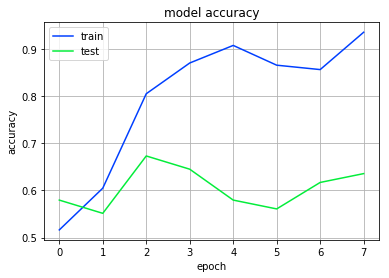

In [97]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

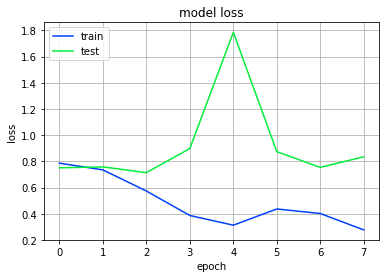

In [98]:
# summarize history for loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
# plt.savefig("model_loss_100_salinas.svg")
plt.show()

In [99]:
validation_size = 35

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.84
acc: 0.64


In [0]:
# print(Y_validate)
# print(np.argmax(Y_validate[1]))

In [0]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
# neu_cnt,
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
#     print(np.argmax(result))
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

In [101]:
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 50.0 %
neg_acc 71.42857142857143 %
